Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


PPO Evaluation saved
Metrics: {'total_return_pct': np.float64(333.293149363671), 'CAGR_pct': np.float64(644.9278914110629), 'volatility_ann_pct': np.float64(12.257764918688792), 'sharpe': np.float64(52.61382443611511), 'max_drawdown_pct': np.float64(-0.0207832634766425), 'calmar': np.float64(31031.117520877902), 'sortino': np.float64(5409.848445861213), 'n_days': 184}


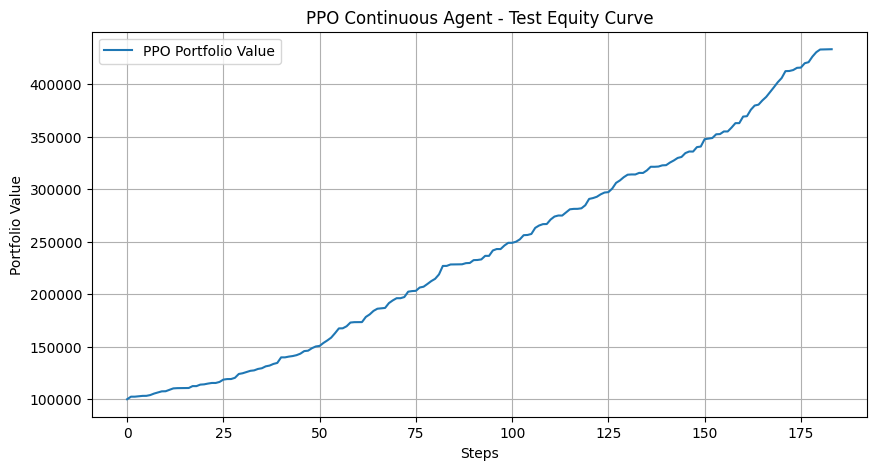

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from stable_baselines3 import PPO

import os, sys
# Setup Project Root
PROJECT_ROOT = r"E:/project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from envs.trading_env_continuous import TradingEnvContinuous
from utils.metrics import equity_to_metrics



# Paths
DATA_PATH = os.path.join(PROJECT_ROOT, "outputs", "datasets", "states_v1_single_asset.npz")
MODEL_DIR = os.path.join(PROJECT_ROOT, "outputs", "models", "ppo_continuous")
SAVE_EVAL = os.path.join(PROJECT_ROOT, "outputs", "evaluations")
PLOT_DIR = os.path.join(PROJECT_ROOT, "outputs", "plots")

os.makedirs(SAVE_EVAL, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# Load Data
data = np.load(DATA_PATH)
X_test = data["X_test"]
prices_test = data["prices"][-len(X_test):]

# ---------- Load PPO Model ----------
model = PPO.load(os.path.join(MODEL_DIR, "ppo_final"))

# ---------- Evaluate ----------
env = TradingEnvContinuous(X_test, prices_test, reward_type="log_return")
obs, _ = env.reset()
done, truncated = False, False
portfolio_values = []

while not (done or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Fixed

# ---------- Metrics ----------
equity = pd.Series(portfolio_values, name="equity", index=np.arange(len(portfolio_values)))

def compute_metrics(equity):
    total_return = (equity.iloc[-1] / equity.iloc[0] - 1) * 100
    n_days = len(equity)
    CAGR = ((equity.iloc[-1] / equity.iloc[0]) ** (252 / n_days) - 1) * 100 if n_days > 0 else 0
    volatility = equity.pct_change().std() * np.sqrt(252) * 100
    sharpe = (CAGR / volatility) if volatility > 0 else 0
    max_dd = ((equity / equity.cummax() - 1).min()) * 100
    calmar = (CAGR / abs(max_dd)) if max_dd != 0 else None
    sortino = (CAGR / (equity.pct_change()[equity.pct_change()<0].std()*np.sqrt(252)*100)) if (equity.pct_change()[equity.pct_change()<0].std() > 0) else 0
    return {
        "total_return_pct": total_return,
        "CAGR_pct": CAGR,
        "volatility_ann_pct": volatility,
        "sharpe": sharpe,
        "max_drawdown_pct": max_dd,
        "calmar": calmar,
        "sortino": sortino,
        "n_days": n_days
    }

metrics = compute_metrics(equity)

# ---------- Save Results ----------
equity.to_csv(os.path.join(SAVE_EVAL, "ppo_continuous_equity_test.csv"), index=False)
with open(os.path.join(SAVE_EVAL, "ppo_continuous_metrics_test.json"), "w") as f:
    json.dump({k: float(v) if v is not None else None for k,v in metrics.items()}, f, indent=4)

plt.figure(figsize=(10,5))
plt.plot(equity, label="PPO Portfolio Value")
plt.title("PPO Continuous Agent - Test Equity Curve")
plt.xlabel("Steps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, "ppo_continuous_equity_test.png"))
# plt.close()

print("PPO Evaluation saved")
print("Metrics:", metrics)
